In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing import Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, END, StateGraph, START
from dotenv import load_dotenv

load_dotenv()

## Tools to use
tavily_tool = TavilySearchResults(max_results=2)

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


# Utility to create a system prompt for each agent
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

llm_with_research_tool = llm.bind_tools([tavily_tool])
llm_with_python_tool = llm.bind_tools([python_repl_tool])

def route_logic(state: MessagesState):
    """Route logic to determine the next node."""
    print("Current state messages:", state["messages"])
    if "FINAL ANSWER" in state["messages"][-1].content:
        return END
    return "chart_generator" if "chart" in \
        state["messages"][-1].content else "researcher"

# Define the research node
def research_node(state: MessagesState):
    """Node for conducting research using the Tavily search tool."""
    messages = state.get("messages", [])
    result = llm_with_research_tool.invoke(messages)
    result[-1] = HumanMessage(content=result[-1].content, name="researcher")
    return {
        "messages": result,
    }

# Define the chart generation node
def chart_node(state: MessagesState):
    """Node for generating charts (placeholder functionality)."""
    messages = state.get("messages", [])
    result = llm_with_python_tool.invoke(messages)
    result[-1] = HumanMessage(content=result[-1].content, name="chart_generator")
    return {
        "messages": result,
    }


# Define the state graph
graph_builder = StateGraph(MessagesState)

# Add nodes to the graph
graph_builder.add_node("researcher", research_node)
graph_builder.add_node("chart_generator", chart_node)

# Add edges to the graph
graph_builder.add_conditional_edges("researcher", route_logic, {"chart_generator": "chart_generator", END: END})
graph_builder.add_conditional_edges("chart_generator", route_logic, {"researcher": "researcher", END: END})

graph_builder.add_edge(START, "researcher")

# Compile the graph
graph = graph_builder.compile()

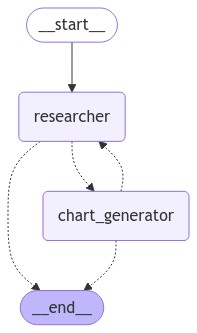

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [3]:
user_input = 'Show me a demographic of the world population'

state = {"messages": [HumanMessage(content=user_input)]}
for event in graph.stream(state):
    print(event)

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n    "tool_calls": [\n        {\n            "id": "pending",\n            "type": "function",\n            "function": {\n                "name": "world_population_demographics"\n            },\n            "parameters": {}\n        }\n    ]\n}\n</tool-use>'}}